<h2>Notation</h2>

<ul>
<li>A -> State Transition Matrix</li>
<li>B -> Control Matrix</li>
<li>H -> Observation Matrix</li>
<li>Q -> Process Noise Covariance</li>
<li>R -> Measurement Noise Covariance</li>
<li>P -> Initial State Covariance Estimate</li>
<li>x0 -> Initial State Estimate</li>
</ul>

In [30]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

np.random.seed(30)

%run ./KF.ipynb

<h1>Example Description</h1>
<p>We have an object moving in the plane and our state(x) is it's position, velocity, and acceleration in the x and y directions. We have 4 nodes in a square/loop which each get measurements of the location every second with different noise. They communicate with their neighbors and weigh estimates equally*(33/100 from two neighbor estimates and 34/100 for personal estimate)</p>
<p>The plots show the Estimates vs Measurements of each of the four nodes and then a convergence plot that averages the error from each of the four nodes.</p>

This is another example where we have an object moving in 2d space with constant acceleration in both the x and y directions.

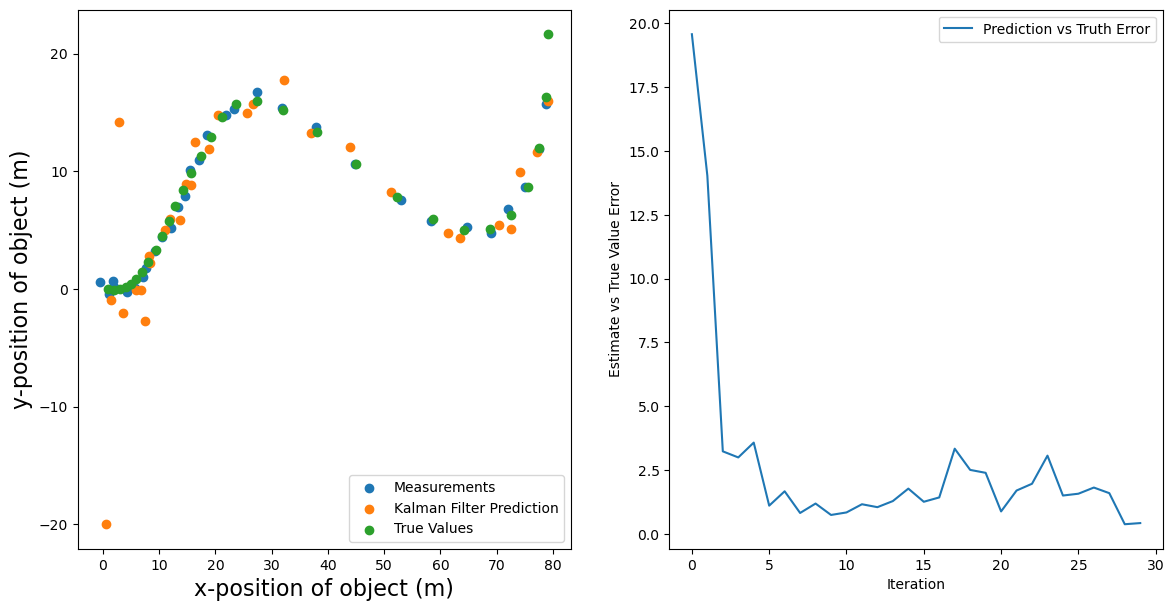

In [31]:
def example1(): #accelerating truck

    #A car moving in 2d with constant acceleration, variables are x, dx, d^2x, y, dy, d^2y and measurements are taken every second
    A = np.array([[1, 1, 0.5, 0, 0, 0], [0, 1, 1, 0, 0, 0],[0,0,1,0,0,0], [0, 0, 0, 1, 1, 0.5], [0,0,0,0,1,1],[0,0,0,0,0,1]])
    H = np.array([[1, 0, 0, 0, 0, 0],[0,0,0,1,0,0]])

    B = np.array([[0,0],[0,0],[1,0],[0,0],[0,0],[0,1]])

    Q = np.array([[0.1, 0, 0, 0, 0, 0], [0, 0.1, 0, 0, 0, 0],[0,0,0.1,0,0,0], [0, 0, 0, 0.1, 0, 0], [0,0,0,0,0.1,0],[0,0,0,0,0,0.1]])
    R = np.array([[0,0],[0,0]])

    #True Initial
    x0 = np.array([[0,1,0,0,0,0]]).T

    #First Estimate
    x = np.array([[0,0,1,-20,0,0]]).T
    

    kf = KalmanFilter(A = A, B=B,H = H, Q = Q, R = R,x0=x)

    measure_var = 0.4

    #For the sake of example the diagram below is with zero process variance
    #Based on the Covariance matrix the intended variance is 0.05
    procc_var = 0.05



    z = (H @ x0)+np.random.normal([[0],[0]],measure_var)

    truth = [A@x0+np.random.normal(np.array([[0,0,0,0,0,0]]).T,procc_var)]
    predictions = []
    measurements = [z]
    errors = []
    for i in range(30):
        #These are control inputs for a "right" turn at t = 15 and a "left" turn at t=20
        if i == 15:
            u = np.array([[1],[-1]])
        elif i == 20:
            u = np.array([[-2],[2]])
        else:
            u = np.array([[0],[0]])

        
        x = np.dot(H,  kf.predict(u))
        predictions.append(x)
        z = np.dot(H,truth[-1])+np.random.normal([[0],[0]],measure_var)
        truth.append(A@truth[-1]+B@u+np.random.normal(np.array([[0,0,0,0,0,0]]).T,procc_var))
        measurements.append(z)
        errors.append(np.linalg.norm(x-z))
        K = kf.update(z)

    fig,axs = plt.subplots(1,2, figsize=(14, 7))
    axs[0].scatter([x[0][0] for x in measurements],[x[1][0] for x in measurements], label = 'Measurements')
    axs[0].scatter([x[0][0] for x in predictions],[x[1][0] for x in predictions], label = 'Kalman Filter Prediction')
    axs[0].scatter([(H@x)[0][0] for x in truth],[(H@x)[1][0] for x in truth], label = 'True Values')
    axs[0].set_xlabel("x-position of object (m)", fontsize = 16)
    axs[0].set_ylabel("y-position of object (m)", fontsize = 16)
    axs[0].legend()
    axs[1].plot([i for i in range(len(errors))],errors, label = 'Prediction vs Truth Error')
    axs[1].legend()
    axs[1].set_xlabel("Iteration")
    axs[1].set_ylabel("Estimate vs True Value Error")
    plt.show()

if __name__ == '__main__':
    example1()

In [32]:
import ipywidgets as widgets
from IPython.display import display
def example2(): # visualize effect of change in measurement variance, x_intial, v_initial
    measure_var_slider = widgets.FloatSlider(value=0.2, min=0, max=1.0, step=0.01, description='Measure Var')
    procc_var_slider = widgets.FloatSlider(value=0.2, min=0, max=1.0, step=0.01, description='Process Var')
    init_x_slider = widgets.FloatSlider(value=0.1, min=-10.0, max=10.0, step=0.1, description='Init x0')
    init_v_slider = widgets.FloatSlider(value= 0.1, min=-10.0, max=10.0, step=0.1, description='Init v0')

    def update_chart(measure_var, procc_var, init_x, init_v):
        A = np.array([[1, 1], [0, 1]])
        H = np.array([[1, 0]])
        Q = np.array([[0.1, 0], [0, 0.1]])
        R = np.array([[measure_var]])
        x0 = np.array([[init_x], [init_v]])
        kf = KalmanFilter(A=A, H=H, Q=Q, R=R, x0=x0)

        z = (H @ x0) + np.random.normal([[0]], measure_var)
        truth = [A @ x0 + np.random.normal([[0],[0]],procc_var)]
        predictions = []
        measurements = [z]
        for _ in range(30):
            predictions.append(kf.predict()[0, 0])
            z = np.dot(H, truth[-1]) + np.random.normal([[0]], measure_var)
            truth.append(A @ truth[-1] + np.random.normal([[0],[0]],procc_var))
            measurements.append(z)
            K = kf.update(z)

        plt.figure(figsize=(10, 6))
        plt.plot([x[0, 0] for x in truth], label='True Position')
        plt.plot(predictions, label='Kalman Filter Prediction')
        plt.scatter(range(31), [x[0, 0] for x in measurements], label='Measurements', color='red')
        plt.legend()
        plt.title(f"Kalman Filter with Measure Var = {measure_var}, Init x0 = {init_x}, Init v0 = {init_v}")
        plt.xlabel('Time Step')
        plt.ylabel('Position')
        plt.show()

    interactive_plot = widgets.interactive(update_chart, measure_var=measure_var_slider, procc_var = procc_var_slider, init_x=init_x_slider, init_v=init_v_slider)
    display(interactive_plot)

if __name__ == '__main__':
    example2()


interactive(children=(FloatSlider(value=0.2, description='Measure Var', max=1.0, step=0.01), FloatSlider(value…

[[0.83333333 0.125      0.         0.        ]
 [0.125      0.025      0.         0.        ]
 [0.         0.         0.83333333 0.125     ]
 [0.         0.         0.125      0.025     ]]


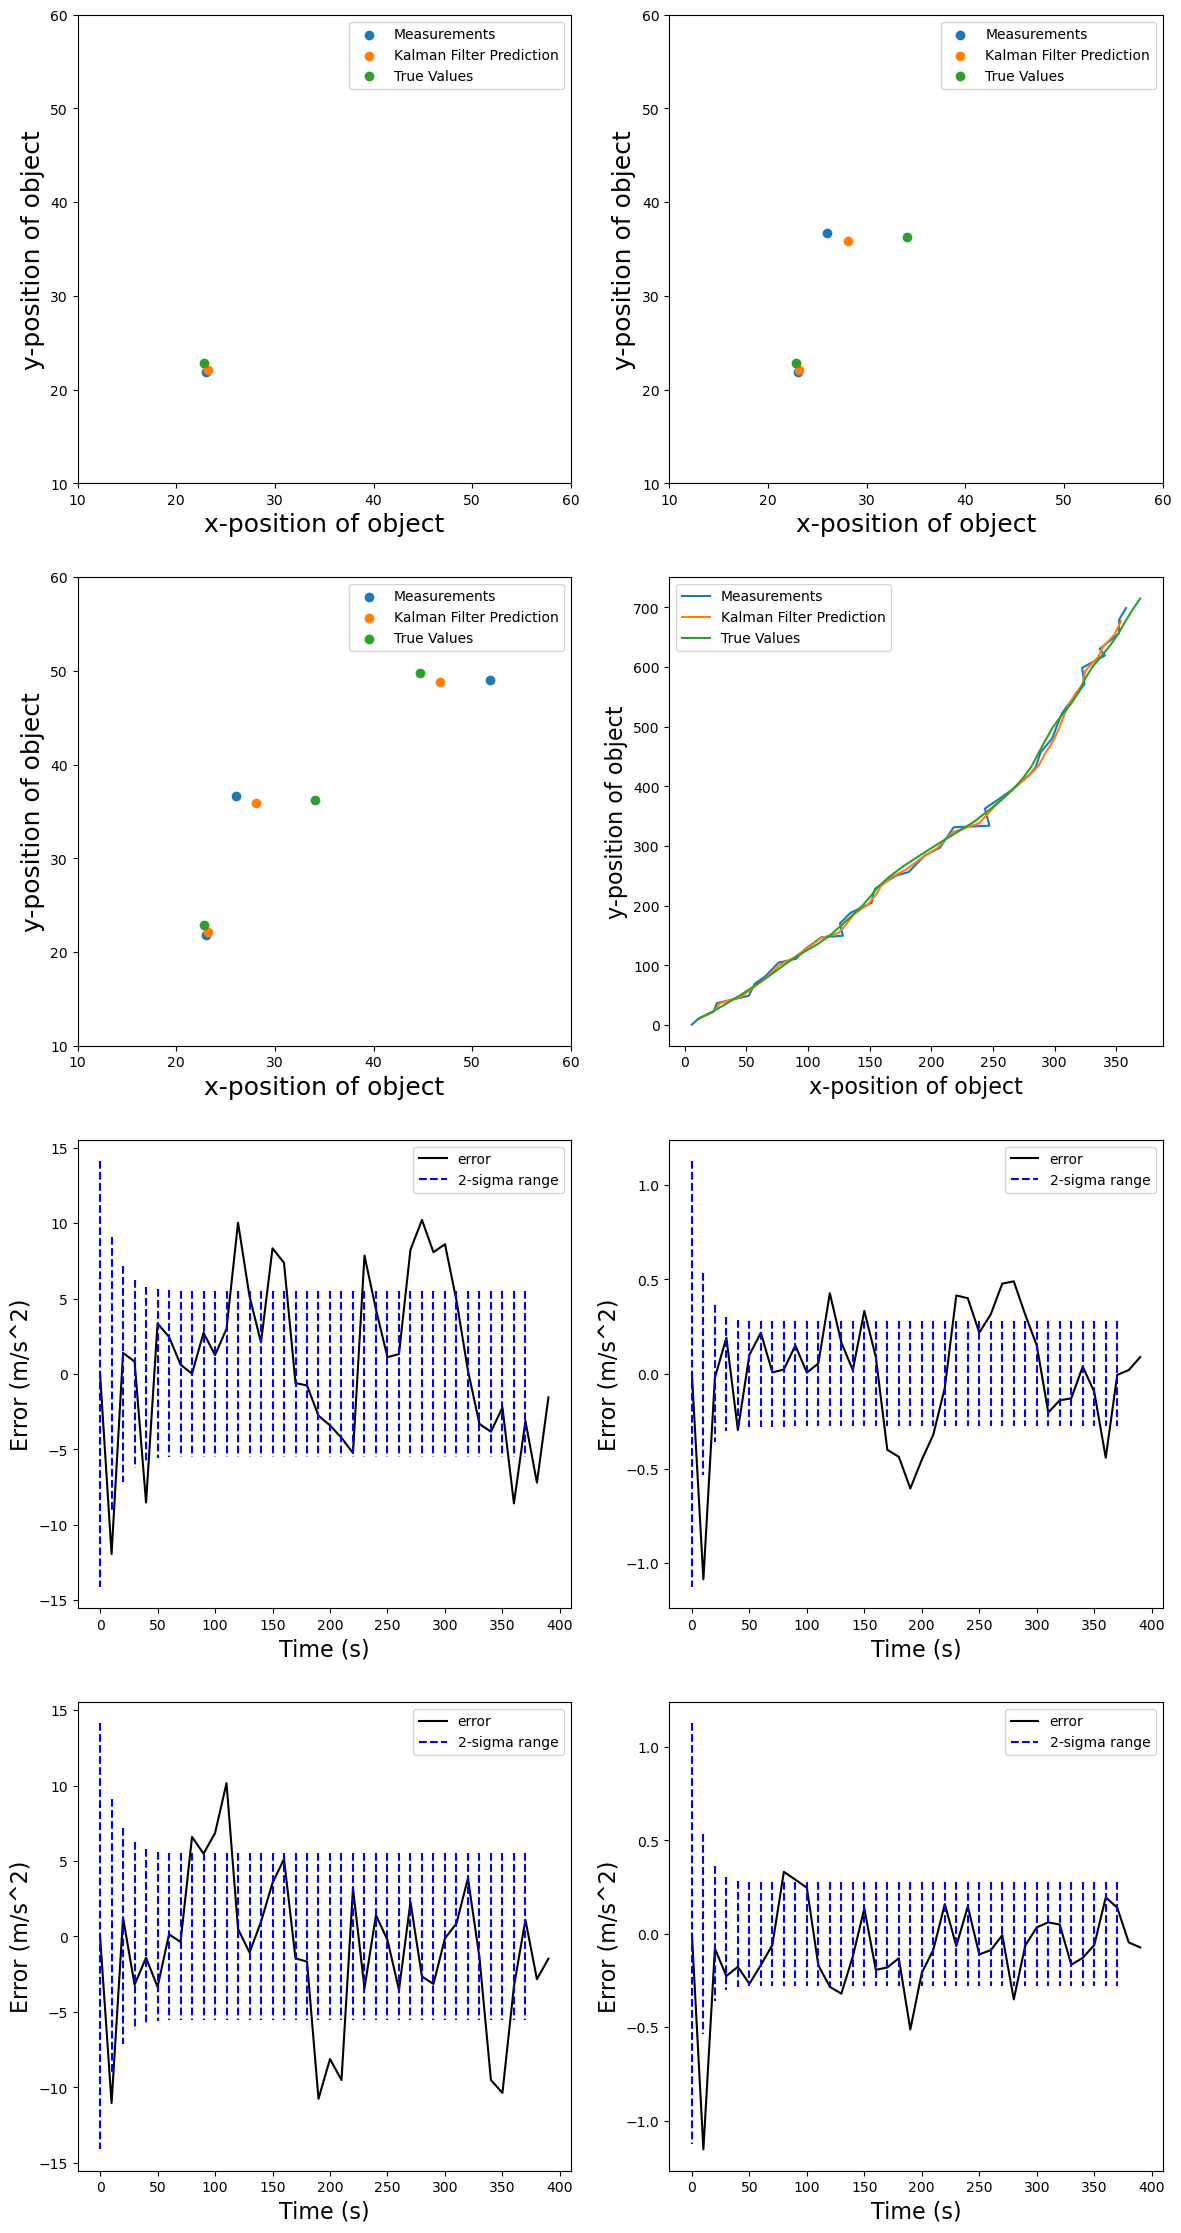

In [37]:
dt = 10
q = 0.0025
n = 40

A = np.array([[1, dt, 0, 0], [0, 1, 0, 0],[0,0,1,dt], [0, 0, 0, 1]])
H = np.array([[1, 0, 0, 0],[0,0,1,0]])

B = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
u = np.array([[0,0,0,0]]).T

Q = q*np.array([[(dt**3)/3, (dt**2)/2, 0, 0], [(dt**2)/2, dt, 0, 0],[0,0,(dt**3)/3,(dt**2)/2], [0, 0, (dt**2)/2, dt]])
print(Q)
R = np.array([[25,0],[0,25]])

#True Initial
x0 = np.array([[0,1,0,1]]).T

#Initial Estimate
x = np.array([[-1,0,-1,0]]).T
P = 100*np.eye(4)
kf = KalmanFilter(A = A, B=B,H = H, Q = Q, R = R,P=P,x0=x)


procc_noise = lambda : np.linalg.cholesky(Q) @ np.random.normal(np.array([[0,0,0,0]]).T)
measure_noise = lambda : np.linalg.cholesky(R) @ np.random.normal(np.array([[0,0]]).T)


truth = [(A@x0)+procc_noise()]
# truth = [(A@x0)]
measurements = [(H @ x0)+measure_noise()]

for i in range(n):
    measurements.append(np.dot(H,truth[-1])+measure_noise())
    truth.append(A@truth[-1]+procc_noise())
    # truth.append(A@truth[-1])

predictions = []
errors = np.zeros((n,4,1))
P_hist = np.zeros((n,4,4))

for i in range(1,n):
    x = H @ kf.predict()
    errors[i]=kf.x-truth[i-1]
    P_hist[i]=(kf.P)
    K = kf.update(measurements[i])
    predictions.append(H@(kf.x))

fig,axs = plt.subplots(4,2, figsize=(14, 28))

axs[0][0].scatter([x[0][0] for x in measurements[2:3]],[x[1][0] for x in measurements[2:3]], label = 'Measurements')
axs[0][0].scatter([x[0][0] for x in predictions[1:2]],[x[1][0] for x in predictions[1:2]], label = 'Kalman Filter Prediction')
axs[0][0].scatter([(H@x)[0][0] for x in truth[1:2]],[(H@x)[1][0] for x in truth[1:2]], label = 'True Values')
axs[0][0].set_xlim(10, 60)
axs[0][0].set_ylim(10, 60)
axs[0][0].set_xlabel("x-position of object", fontsize = 18)
axs[0][0].set_ylabel("y-position of object", fontsize = 18)
axs[0][0].legend()

axs[0][1].scatter([x[0][0] for x in measurements[2:4]],[x[1][0] for x in measurements[2:4]], label = 'Measurements')
axs[0][1].scatter([x[0][0] for x in predictions[1:3]],[x[1][0] for x in predictions[1:3]], label = 'Kalman Filter Prediction')
axs[0][1].scatter([(H@x)[0][0] for x in truth[1:3]],[(H@x)[1][0] for x in truth[1:3]], label = 'True Values')
axs[0][1].set_xlim(10, 60)
axs[0][1].set_ylim(10, 60)
axs[0][1].set_xlabel("x-position of object", fontsize = 18)
axs[0][1].set_ylabel("y-position of object", fontsize = 18)
axs[0][1].legend()

axs[1][0].scatter([x[0][0] for x in measurements[2:5]],[x[1][0] for x in measurements[2:5]], label = 'Measurements')
axs[1][0].scatter([x[0][0] for x in predictions[1:4]],[x[1][0] for x in predictions[1:4]], label = 'Kalman Filter Prediction')
axs[1][0].scatter([(H@x)[0][0] for x in truth[1:4]],[(H@x)[1][0] for x in truth[1:4]], label = 'True Values')
axs[1][0].set_xlim(10, 60)
axs[1][0].set_ylim(10, 60)
axs[1][0].set_xlabel("x-position of object", fontsize = 18)
axs[1][0].set_ylabel("y-position of object", fontsize = 18)
axs[1][0].legend()

axs[1][1].plot([x[0][0] for x in measurements],[x[1][0] for x in measurements], label = 'Measurements')
axs[1][1].plot([x[0][0] for x in predictions],[x[1][0] for x in predictions], label = 'Kalman Filter Prediction')
axs[1][1].plot([(H@x)[0][0] for x in truth],[(H@x)[1][0] for x in truth], label = 'True Values')
axs[1][1].set_xlabel("x-position of object", fontsize = 16)
axs[1][1].set_ylabel("y-position of object", fontsize = 16)
axs[1][1].legend()

t_hist = np.arange(0, 10*n, 10)

for k in range(2,6):
    axs[k//2+1][k%2].plot(t_hist, errors[:, k-2], 'k')
    axs[k//2+1][k%2].plot(np.vstack([t_hist[:n-2], t_hist[:n-2]]), np.vstack([np.sqrt(P_hist[2:, k-2, k-2]), -np.sqrt(P_hist[2:, k-2, k-2])]), 'b--')
    axs[k//2+1][k%2].set_xlabel("Time (s)", fontsize = 16)
    axs[k//2+1][k%2].set_ylabel("Error (m/s^2)", fontsize = 16)
    axs[k//2+1][k%2].legend(["error","2-sigma range"])
plt.show()
